# Results

In [1]:
%load_ext autoreload
%autoreload 2

In [236]:
from ccd import CCD
from fci import FCI
from hfock import solve_hfock
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['lines.markeredgewidth'] = 3
plt.rcParams.update({'font.size': 18})

In [53]:
# Helper functions
def energy(mb_object):
    """ Return the energy of the lowest energy state """
    if isinstance(mb_object, CCD):
        return mb_object.solve()[0][0]
    elif isinstance(mb_object, FCI):
        return mb_object.energy_states()[0][0]
    return mb_object[0][-1]
    

# Illustrate convergence

## For non-Hartreefock basis

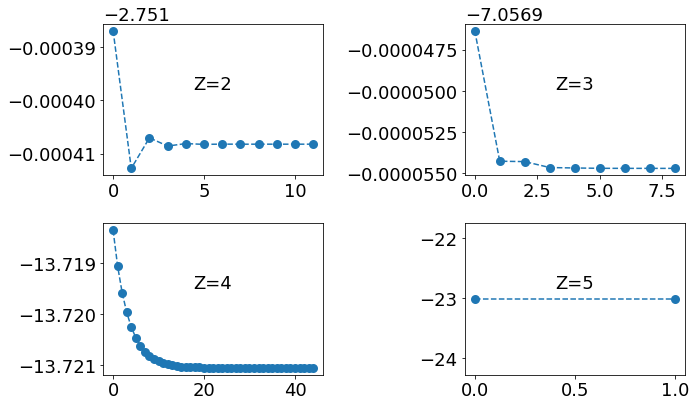

In [237]:
fig = plt.figure(figsize=(10, 6))
for Z in range(2, 6):
    ax = fig.add_subplot(2, 2, Z-1)
    ccd = CCD(Z)
    E, _ = ccd.solve()
    ax.plot(E, 'o--')
    ax.text(0.5, 0.6, f"Z={Z}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.savefig('../figures/convergence.eps')
plt.show()

## For HartreeFock basis

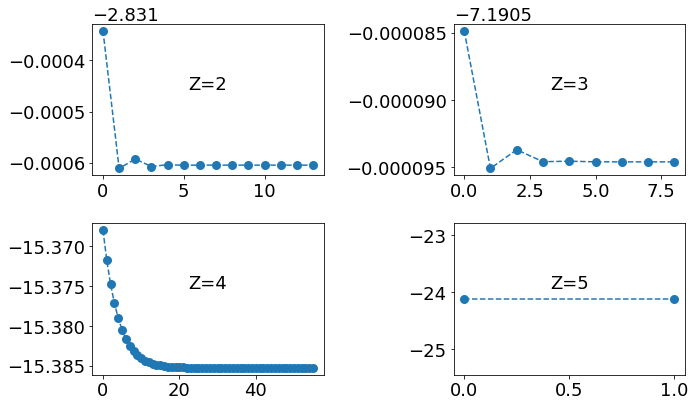

In [238]:
fig = plt.figure(figsize=(10, 6))
for Z in range(2, 6):
    ax = fig.add_subplot(2, 2, Z-1)
    ccd = CCD(Z)
    ccd.transform_to_hfock()
    E, _ = ccd.solve()
    ax.plot(E, 'o--')
    ax.text(0.5, 0.6, f"Z={Z}", transform=ax.transAxes,
            horizontalalignment='center', verticalalignment='center')
plt.tight_layout()
plt.savefig('../figures/hfconvergence.eps')
plt.show()

# Compare CCD, FCI and HFOCK

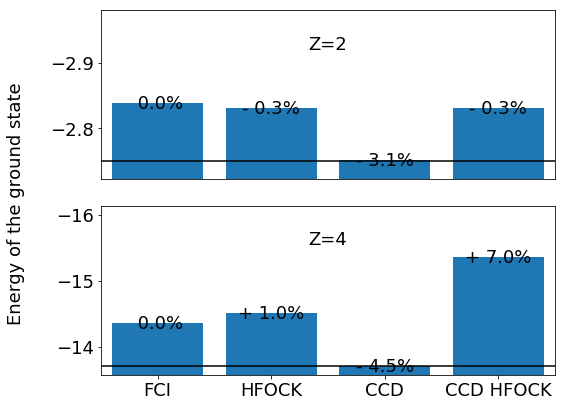

In [239]:
def barplot(Z, ax):
    fci = FCI(Z)
    ccd = CCD(Z)
    ccd_hfock = CCD(Z)
    ccd_hfock.transform_to_hfock()
    hfock = solve_hfock(fci, verbose=False)

    E_fci = energy(fci)
    E_ccd = energy(ccd)
    E_ccd_hfock = energy(ccd_hfock)
    E_hfock = energy(hfock)

    ax.bar([1, 2, 3, 4], 
           [E_fci, E_hfock, E_ccd, E_ccd_hfock])
    ax.set_ylim(top=fci.Eref*.99)
    ax.hlines(fci.Eref, xmin=0, xmax=5)
    ax.set_xlim(0.5, 4.5)
    offset = 0.05*(ax.get_ylim()[0] - ax.get_ylim()[1])

    for x, E in enumerate((E_fci, E_hfock, E_ccd, E_ccd_hfock)):
        x += 1
        percent = E/E_fci*100-100
        if percent > 0:
            sign = '+'
        elif percent < 0:
            sign = '-'
        else:
            sign = ''
        ax.text(x, E+offset, f'{sign} {abs(percent):.1f}%',
                ha='center', va='top')
        
    ax.text(0.5, 0.8, f'Z={Z}', horizontalalignment='center',
           verticalalignment='center', transform=ax.transAxes)
    return ax

fig, axes = plt.subplots(2, sharex=True, figsize=(8,6))
barplot(2, axes[0])
barplot(4, axes[1])

axes[0].xaxis.set_tick_params(which='both', length=0)
axes[1].set_xticks([1, 2, 3, 4], minor=False)
plt.setp(axes[0].get_xticklabels(), visible=False)
axes[1].set_xticklabels(['FCI', 'HFOCK', 'CCD', 'CCD HFOCK'])
#plt.setp(axes[0].get_xticklabels(), visible=True)
fig.text(.025, 0.5, "Energy of the ground state", rotation="vertical",
        transform=fig.transFigure, horizontalalignment='center',
        verticalalignment='center')
[a.invert_yaxis() for a in axes]
plt.tight_layout(rect=(0.05, 0, 1, 1))
plt.savefig('../figures/relativetofci.eps')
plt.show()

## Run through all the states

In [124]:
def CCD_hfock(Z):
    ccd = CCD(Z)
    ccd.transform_to_hfock()
    return ccd

def hfock(Z):
    return solve_hfock(FCI(Z), verbose=False)

Es = []
for Method, label in tqdm(zip([FCI, CCD, CCD_hfock, hfock],
                         ['FCI', 'CCD', 'CCD HFOCK', 'HFOCK'])):
    E = np.array([energy(Method(Z)) for Z in range(2, 6)])
    Es.append((E, label))



0it [00:00, ?it/s]

1it [00:03,  3.77s/it]

2it [00:07,  3.83s/it]

3it [00:11,  3.91s/it]

4it [00:15,  3.86s/it]

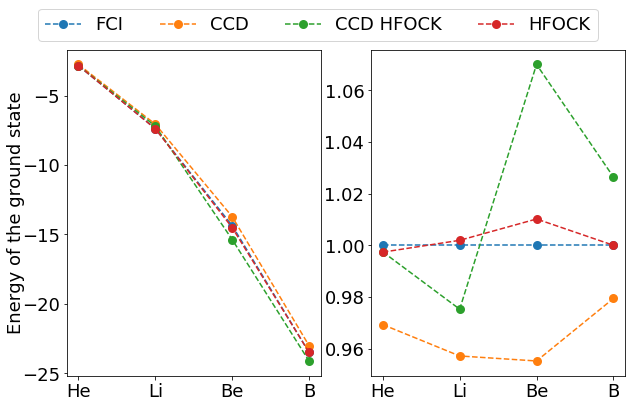

In [240]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
for E, label in Es:
    ax[0].plot(E, 'o--', label=label)
   
Ees = [np.array(i) for i in list(zip(*list(zip(*Es))[0]))]
Ees = [e/e[0] for e in Ees]
ax[1].plot(Ees, 'o--')

ax[0].set_xticks([0, 1, 2, 3])
ax[1].set_xticks([0, 1, 2, 3])
ax[0].set_xticklabels(['He', 'Li', 'Be', 'B'])
ax[1].set_xticklabels(['He', 'Li', 'Be', 'B'])
fig.text(-0.2, 0.5, "Energy of the ground state", rotation="vertical",
        transform=ax[0].transAxes, horizontalalignment='center',
        verticalalignment='center')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4)
plt.savefig('../figures/comparison.eps')
plt.show()